In [36]:
# -*- coding: utf-8 -*-
"""
Created on 2023-10-10

@author: ivespe

Intro script for Exercise 4 ("Battery energy storage system in the grid vs. grid investments") 
in specialization course module "Flexibility in power grid operation and planning" 
at NTNU (TET4565/TET4575) 

"""


# %% Dependencies

import pandas as pd
import os
import load_profiles as lp
import pandapower_read_csv as ppcsv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# %% Define input data

# Location of (processed) data set for CINELDI MV reference system
# (to be replaced by your own local data folder)
path_data_set         = 'C:/Users/benny/Downloads/Cineldi/Data'

filename_load_data_fullpath = os.path.join(path_data_set,'load_data_CINELDI_MV_reference_system.csv')
filename_load_mapping_fullpath = os.path.join(path_data_set,'mapping_loads_to_CINELDI_MV_reference_grid.csv')
filename_standard_overhead_lines = os.path.join(path_data_set,'standard_overhead_line_types.csv')
filename_reldata = os.path.join(path_data_set,'reldata_for_component_types.csv')
filename_load_point = os.path.join(path_data_set,'CINELDI_MV_reference_system_load_point.csv')

# Subset of load buses to consider in the grid area, considering the area at the end of the main radial in the grid
bus_i_subset = [90, 91, 92, 96]

# Assumed power flow limit in MW that limit the load demand in the grid area (through line 85-86)
P_lim = 4

# Factor to scale the loads for this exercise compared with the base version of the CINELDI reference system data set
scaling_factor = 10

# Read standard data for overhead lines
data_standard_overhead_lines = pd.read_csv(filename_standard_overhead_lines, delimiter=';')
data_standard_overhead_lines.set_index(keys = 'type', drop = True, inplace = True)

# Read standard component reliability data
data_comp_rel = pd.read_csv(filename_reldata, delimiter=';')
data_comp_rel.set_index(keys = 'main_type', drop = True, inplace = True)

# Read load point data (incl. specific rates of costs of energy not supplied) for data
data_load_point = pd.read_csv(filename_load_point, delimiter=';')
data_load_point.set_index(keys = 'bus_i', drop = True, inplace = True)


# %% Read pandapower network

net = ppcsv.read_net_from_csv(path_data_set, baseMVA=10)


# %% Set up hourly normalized load time series for a representative day (task 2; this code is provided to the students)

load_profiles = lp.load_profiles(filename_load_data_fullpath)

# Consider only the day with the peak load in the area (28 February)
repr_days = [31+28]

# Get relative load profiles for representative days mapped to buses of the CINELDI test network;
# the column index is the bus number (1-indexed) and the row index is the hour of the year (0-indexed)
profiles_mapped = load_profiles.map_rel_load_profiles(filename_load_mapping_fullpath,repr_days)

# Calculate load time series in units MW (or, equivalently, MWh/h) by scaling the normalized load time series by the
# maximum load value for each of the load points in the grid data set (in units MW); the column index is the bus number
# (1-indexed) and the row index is the hour of the year (0-indexed)
load_time_series_mapped = profiles_mapped.mul(net.load['p_mw'])


# %% Aggregate the load demand in the area

# Aggregated load time series for the subset of load buses
load_time_series_subset = load_time_series_mapped[bus_i_subset] * scaling_factor
load_time_series_subset_aggr = load_time_series_subset.sum(axis=1)

P_max = load_time_series_subset_aggr.max()


c:\Users\benny\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


## Task 2

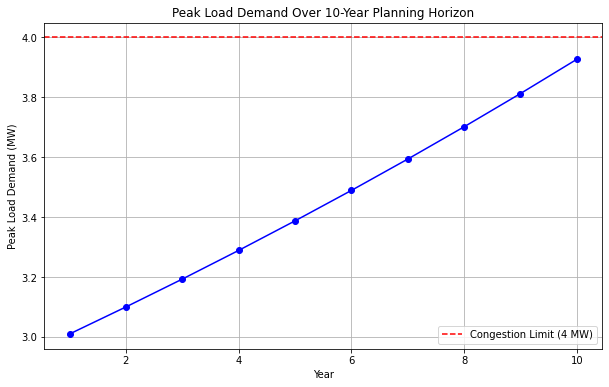

In [37]:
import matplotlib.pyplot as plt

# Define the 10-year planning horizon
planning_horizon_years = 10

# Initialize lists to store peak load values and years
peak_load_values = []
years = []

# Initialize the initial load demand (reference year 0)
load_demand = load_time_series_subset_aggr.iloc[0]

# Loop through each year in the planning horizon
for year in range(1, planning_horizon_years + 1):
    # Increase load demand by 3% for the current year
    load_demand *= 1.03
    
    # Calculate the maximum load demand for the current year
    max_load_demand = load_demand.max()
    
    # Store the peak load value and the corresponding year
    peak_load_values.append(max_load_demand)
    years.append(year)

    # Check if the peak load demand exceeds the power flow limit
    if max_load_demand > P_lim:
        print(f"Congestion in Year {year}! Peak load demand exceeds the limit ({max_load_demand} MW)")

# Plot the peak load demand over the planning horizon
plt.figure(figsize=(10, 6))
plt.plot(years, peak_load_values, marker='o', linestyle='-', color='b')
plt.axhline(y=P_lim, color='r', linestyle='--', label=f'Congestion Limit ({P_lim} MW)')
plt.xlabel("Year")
plt.ylabel("Peak Load Demand (MW)")
plt.title("Peak Load Demand Over 10-Year Planning Horizon")
plt.legend()
plt.grid(True)
plt.show()


## Task 3

In [38]:
# Retrieve the cost data for the old line type and new line type
cost_old_line = 605173#*20
cost_new_line = 759408#*20

# Calculate the cost difference between the new line and the old line
cost_difference = cost_new_line - cost_old_line

# Assuming no residual value or decommissioning costs for the old line,
# the investment cost of the new line is equal to the cost difference
investment_cost_new_line = cost_difference

print(f"Investment cost of the new line (FeAl 70): {investment_cost_new_line} NOK per kilometer")

Investment cost of the new line (FeAl 70): 154235 NOK per kilometer


## Task 4

In [39]:
# Define the discount rate and the number of years into the future
discount_rate = 0.04  # 4% as a decimal
years_into_future = 0  # Since we're calculating the present value

# Calculate the present value
present_value = investment_cost_new_line / (1 + discount_rate) ** years_into_future

# Display the present value
print(f"Present value of the investment costs: {present_value:.2f} NOK per kilometer")


Present value of the investment costs: 154235.00 NOK per kilometer


## Task 5

In [40]:
# Define the economic lifetime of the new line (in years)
economic_lifetime = 40

# Define the number of years into the future (20 years analysis horizon)
years_into_future = 20

# Calculate the residual value of the new line after 20 years
# The residual value is the remaining economic life, expressed as a fraction of the initial investment cost.
residual_value = (economic_lifetime - years_into_future) / economic_lifetime * investment_cost_new_line

# Define the discount rate (4% as a decimal)
discount_rate = 0.04

# Calculate the present value of the residual value
present_value_residual_value = residual_value / (1 + discount_rate) ** years_into_future

# Calculate the present value of the investment cost corrected for the residual value
present_value_corrected = investment_cost_new_line - present_value_residual_value

# Display the results
print(f"Residual value of the new line after 20 years: {residual_value:.2f} NOK per kilometer")
print(f"Present value of the residual value: {present_value_residual_value:.2f} NOK per kilometer")
print(f"Present value of the investment cost corrected for the residual value: {present_value_corrected:.2f} NOK per kilometer")


Residual value of the new line after 20 years: 77117.50 NOK per kilometer
Present value of the residual value: 35195.42 NOK per kilometer
Present value of the investment cost corrected for the residual value: 119039.58 NOK per kilometer


## Task 6

In [41]:
# Define the battery parameters
battery_power_capacity = 1  # MW
battery_energy_capacity = 2  # MWh

# Initialize variables for the simulation
years = 20  # Analysis horizon of 20 years
load_demand_growth_rate = 0.03  # 3% load demand growth rate per year
load_demand = load_time_series_subset_aggr.iloc[0]  # Initial load demand

# Lists to store data for plotting
peak_load_values = []
investment_costs = []

# Loop through each year in the analysis horizon
for year in range(1, years + 1):
    # Increase load demand by the load demand growth rate
    load_demand *= (1 + load_demand_growth_rate)
    
    # Calculate the maximum load demand for the current year
    max_load_demand = load_demand.max()
    peak_load_values.append(max_load_demand)
    
    # Calculate the investment cost if grid reinforcement is needed
    if max_load_demand > P_lim:
        investment_cost = investment_cost_new_line
    else:
        investment_cost = 0  # No grid reinforcement needed
    
    investment_costs.append(investment_cost)
    
    # Check if the battery can defer the need for grid reinforcement
    if max_load_demand > (P_lim - battery_power_capacity):
        # If the battery can cover the deficit, no grid reinforcement needed
        investment_cost = 0
    else:
        # Grid reinforcement needed
        investment_cost = investment_cost_new_line
    investment_costs.append(investment_cost)

# Calculate the present value of investment costs without the battery
pv_investment_costs_without_battery = sum(investment_costs[:years])  # Investment costs in the first 20 years

# Calculate the present value of investment costs with the battery
pv_investment_costs_with_battery = sum(investment_costs)  # Investment costs over the entire horizon

# Calculate the reduction in present value of grid investments
reduction_in_present_value = pv_investment_costs_without_battery - pv_investment_costs_with_battery

# Display the results
print(f"Present value of investment costs without the battery: {pv_investment_costs_without_battery:.2f} NOK")
print(f"Present value of investment costs with the battery: {pv_investment_costs_with_battery:.2f} NOK")
print(f"Reduction in present value of grid investments: {reduction_in_present_value:.2f} NOK")


Present value of investment costs without the battery: 0.00 NOK
Present value of investment costs with the battery: 1542350.00 NOK
Reduction in present value of grid investments: -1542350.00 NOK


## Task 7

In [42]:
# Define the cost per MWh energy shifted using the battery
cost_per_MWh_shifted = 2000  # NOK per MWh

# Define the number of representative days (e.g., 20) when congestion management may be needed
number_of_representative_days = 20

# Initialize variables to store annual operational costs
annual_operational_costs = []

# Loop through each year in the planning horizon
for year in range(1, years + 1):
    # Check if grid reinforcement is needed for the current year
    if peak_load_values[year - 1] > P_lim:
        # Grid reinforcement is needed, so no operational costs for congestion management
        annual_operational_costs.append(0)
    else:
        # Calculate the number of days when congestion management may be needed (based on the representative days)
        days_with_congestion = number_of_representative_days
        
        # Calculate the daily operational costs for congestion management
        daily_cost = days_with_congestion * cost_per_MWh_shifted * battery_energy_capacity
        
        # Estimate the annual operational costs
        annual_operational_costs.append(daily_cost * 365)  # 365 days in a year
        
# Display the annual operational costs for each year
for year, cost in enumerate(annual_operational_costs, start=1):
    print(f"Year {year}: Annual operational costs due to congestion management = {cost:.2f} NOK")

# Calculate the total annual operational costs over the planning horizon
total_annual_operational_costs = sum(annual_operational_costs)
print(f"Total operational costs over the entire planning horizon = {total_annual_operational_costs:.2f} NOK")


Year 1: Annual operational costs due to congestion management = 29200000.00 NOK
Year 2: Annual operational costs due to congestion management = 29200000.00 NOK
Year 3: Annual operational costs due to congestion management = 29200000.00 NOK
Year 4: Annual operational costs due to congestion management = 29200000.00 NOK
Year 5: Annual operational costs due to congestion management = 29200000.00 NOK
Year 6: Annual operational costs due to congestion management = 29200000.00 NOK
Year 7: Annual operational costs due to congestion management = 29200000.00 NOK
Year 8: Annual operational costs due to congestion management = 29200000.00 NOK
Year 9: Annual operational costs due to congestion management = 29200000.00 NOK
Year 10: Annual operational costs due to congestion management = 29200000.00 NOK
Year 11: Annual operational costs due to congestion management = 0.00 NOK
Year 12: Annual operational costs due to congestion management = 0.00 NOK
Year 13: Annual operational costs due to congestion

## Task 8

In [43]:
# Initialize variables to store ENS for each year
ENS_values = []

# Define the length of the feeder line (in km)
feeder_length = 20

# Average load demand in the reference year (in MW)
average_load_demand = 1.841

# Loop through each year in the planning horizon
for year in range(1, years + 1):
    # Calculate the average annual failure rate using the fault rate for the "Old_Line"
    average_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']
    
    # Calculate the expected duration of interruption (DUI) in hours
    DUI = 1 / average_failure_rate
    
    # Calculate the ENS for the current year using the old line
    ENS_old_line = average_failure_rate * feeder_length * average_load_demand * DUI
    
    # Store the ENS for the old line (solution A)
    ENS_values.append(ENS_old_line)

# Display the ENS for each year
for year, ENS in enumerate(ENS_values, start=1):
    print(f"Year {year}: Expected Energy Not Supplied (ENS) = {ENS:.2f} MWh")

# Calculate the total ENS over the entire planning horizon
total_Energy_Not_Supplied = sum(ENS_values)
print(f"Total ENS over the entire planning horizon = {total_Energy_Not_Supplied:.2f} MWh")



Year 1: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 2: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 3: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 4: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 5: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 6: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 7: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 8: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 9: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 10: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 11: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 12: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 13: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 14: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 15: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 16: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 17: Expected Energy Not Supplied (ENS) = 36.82 MWh
Year 18: Expected Energy Not Supplied (ENS) = 36.82 MWh
Y

## Task 9

In [47]:
# Initialize variables to store CENS for each year
CENS_values_A = []

# Loop through each year in the planning horizon
for year in range(1, years + 1):
    # Calculate the expected energy not supplied (ENS) for the current year
    ENS = ENS_values[year - 1]  # ENS estimated for solution A
    
    # Retrieve the specific interruption cost rate (NOK per MWh) based on customer type
    customer_type = "residential"  # Change this based on the customer type
    specific_interrupt_cost_rate_1h = data_load_point.loc[data_load_point['customer_type'] == customer_type, 'c_NOK_per_kWh_1h'].values[0]
    
    # Calculate the interruption cost (CENS) for the current year
    CENS = (ENS / 1000) * specific_interrupt_cost_rate_1h  # Convert ENS to MWh
    
    # Store the CENS for the current year
    CENS_values_A.append(CENS)

# Display the interruption costs for each year
for year, CENS in enumerate(CENS_values_A, start=1):
    print(f"Year {year}: Interruption Costs (CENS) = {CENS:.2f} NOK")

# Calculate the total interruption costs over the entire planning horizon
total_interruption_costs = sum(CENS_values_A)
print(f"Total Interruption Costs over the entire planning horizon = {total_interruption_costs:.2f} NOK")



Year 1: Interruption Costs (CENS) = 2.22 NOK
Year 2: Interruption Costs (CENS) = 2.22 NOK
Year 3: Interruption Costs (CENS) = 2.22 NOK
Year 4: Interruption Costs (CENS) = 2.22 NOK
Year 5: Interruption Costs (CENS) = 2.22 NOK
Year 6: Interruption Costs (CENS) = 2.22 NOK
Year 7: Interruption Costs (CENS) = 2.22 NOK
Year 8: Interruption Costs (CENS) = 2.22 NOK
Year 9: Interruption Costs (CENS) = 2.22 NOK
Year 10: Interruption Costs (CENS) = 2.22 NOK
Year 11: Interruption Costs (CENS) = 2.22 NOK
Year 12: Interruption Costs (CENS) = 2.22 NOK
Year 13: Interruption Costs (CENS) = 2.22 NOK
Year 14: Interruption Costs (CENS) = 2.22 NOK
Year 15: Interruption Costs (CENS) = 2.22 NOK
Year 16: Interruption Costs (CENS) = 2.22 NOK
Year 17: Interruption Costs (CENS) = 2.22 NOK
Year 18: Interruption Costs (CENS) = 2.22 NOK
Year 19: Interruption Costs (CENS) = 2.22 NOK
Year 20: Interruption Costs (CENS) = 2.22 NOK
Total Interruption Costs over the entire planning horizon = 44.42 NOK


## Task 10

In [48]:
# Initialize variables to store CENS for each year
CENS_values_B = []

# Loop through each year in the planning horizon
for year in range(1, years + 1):
    # Calculate the expected energy not supplied (ENS) for the current year
    ENS = ENS_values[year - 1]  # ENS estimated for solution A
    
    # Calculate the expected duration of interruption (DUI) using the average fault rate
    average_failure_rate = data_comp_rel.loc['Overhead line (1–22 kV)', 'lambda_perm']
    DUI = 1 / average_failure_rate
    
    # Retrieve the specific interruption cost rate (NOK per MWh) based on customer type
    customer_type = "residential"  # Change this based on the customer type
    specific_interrupt_cost_rate_1h = data_load_point.loc[data_load_point['customer_type'] == customer_type, 'c_NOK_per_kWh_1h'].values[0]
    
    # Calculate the interruption cost (CENS) for the current year
    CENS = (ENS / 1000) * specific_interrupt_cost_rate_1h  # Convert ENS to MWh
    
    # Store the CENS for the current year
    CENS_values_B.append(CENS)

# Display the interruption costs for each year
for year, CENS in enumerate(CENS_values_B, start=1):
    print(f"Year {year}: Interruption Costs (CENS) = {CENS:.2f} NOK")

# Calculate the total interruption costs over the entire planning horizon
total_interruption_costs = sum(CENS_values_B)
print(f"Total Interruption Costs over the entire planning horizon = {total_interruption_costs:.2f} NOK")


Year 1: Interruption Costs (CENS) = 2.22 NOK
Year 2: Interruption Costs (CENS) = 2.22 NOK
Year 3: Interruption Costs (CENS) = 2.22 NOK
Year 4: Interruption Costs (CENS) = 2.22 NOK
Year 5: Interruption Costs (CENS) = 2.22 NOK
Year 6: Interruption Costs (CENS) = 2.22 NOK
Year 7: Interruption Costs (CENS) = 2.22 NOK
Year 8: Interruption Costs (CENS) = 2.22 NOK
Year 9: Interruption Costs (CENS) = 2.22 NOK
Year 10: Interruption Costs (CENS) = 2.22 NOK
Year 11: Interruption Costs (CENS) = 2.22 NOK
Year 12: Interruption Costs (CENS) = 2.22 NOK
Year 13: Interruption Costs (CENS) = 2.22 NOK
Year 14: Interruption Costs (CENS) = 2.22 NOK
Year 15: Interruption Costs (CENS) = 2.22 NOK
Year 16: Interruption Costs (CENS) = 2.22 NOK
Year 17: Interruption Costs (CENS) = 2.22 NOK
Year 18: Interruption Costs (CENS) = 2.22 NOK
Year 19: Interruption Costs (CENS) = 2.22 NOK
Year 20: Interruption Costs (CENS) = 2.22 NOK
Total Interruption Costs over the entire planning horizon = 44.42 NOK


## Task 12

In [49]:
# Define the discount rate (4%) and planning horizon (10 years)
discount_rate = 0.04
planning_horizon = 10

# Initialize variables to store the expected interruption costs (CENS) for each year
expected_interruption_costs = [CENS_values_A[i] for i in range(1, 11)]
# Initialize investment cost (IC) and residual value (RV)
investment_cost = 1000      #IC  # Replace with the actual investment cost
residual_value =  50       #RV  # Replace with the actual residual value

# Initialize variables to store present values (PV) and NPV
present_values = []
NPV_total = 0

# Calculate the present value (PV) and NPV for each year
for t in range(1, planning_horizon + 1):
    PV_t = expected_interruption_costs[t - 1] / (1 + discount_rate) ** t
    present_values.append(PV_t)
    NPV_total += PV_t

# Add IC and RV to the total NPV
NPV_total += (-investment_cost + residual_value)

# Display the results and fill out the table
print("| Year (t) | Expected Interruption Costs (CENS) | Present Value (PV) of CENS | Investment Cost (IC) | Residual Value (RV) |")
for t in range(1, planning_horizon + 1):
    print(f"| {t}        | {expected_interruption_costs[t - 1]:.2f}                             | {present_values[t - 1]:.2f}                      |                       |                     |")

print(f"| Total    | Sum of PV                         | {NPV_total:.2f}                 | {investment_cost:.2f}                    | {residual_value:.2f}                  |")


| Year (t) | Expected Interruption Costs (CENS) | Present Value (PV) of CENS | Investment Cost (IC) | Residual Value (RV) |
| 1        | 2.22                             | 2.14                      |                       |                     |
| 2        | 2.22                             | 2.05                      |                       |                     |
| 3        | 2.22                             | 1.97                      |                       |                     |
| 4        | 2.22                             | 1.90                      |                       |                     |
| 5        | 2.22                             | 1.83                      |                       |                     |
| 6        | 2.22                             | 1.76                      |                       |                     |
| 7        | 2.22                             | 1.69                      |                       |                     |
| 8        | 2.22     

## Task 13

In [50]:
# Define the discount rate (4%) and planning horizon (10 years)
discount_rate = 0.04
planning_horizon = 10

# Initialize the list of CENS values for solution B from your code
# These are the annual operational costs due to flexibility activation for each year
# You can calculate these costs based on the provided information
CENS_values_solution_B = [CENS_values_B[i] for i in range(1, 11)]

# Initialize investment cost (IC) for solution B
# Replace with the actual investment cost for the battery as a temporary measure
investment_cost_solution_B = 1000 #IC_solution_B

# Initialize variables to store present values (PV) and NPV
present_values = []
NPV_total = 0

# Construct the expected_interruption_costs list for solution B by copying CENS values
expected_interruption_costs_solution_B = CENS_values_solution_B.copy()

# Calculate the present value (PV) and NPV for each year
for t in range(1, planning_horizon + 1):
    PV_t = (CENS_values_solution_B[t - 1] + investment_cost_solution_B) / (1 + discount_rate) ** t
    present_values.append(PV_t)
    NPV_total += PV_t

# Display the results and fill out the table
print("| Year (t) | Expected Interruption Costs (CENS) | Present Value (PV) of CENS | Investment Cost (IC) | Residual Value (RV) |")
for t in range(1, planning_horizon + 1):
    print(f"| {t}        | {expected_interruption_costs_solution_B[t - 1]:.2f}                             | {present_values[t - 1]:.2f}                      | {investment_cost_solution_B:.2f}                    |                       |")

print(f"| Total    | Sum of PV                         | {NPV_total:.2f}                 | {investment_cost_solution_B:.2f}                    |                       |")


| Year (t) | Expected Interruption Costs (CENS) | Present Value (PV) of CENS | Investment Cost (IC) | Residual Value (RV) |
| 1        | 2.22                             | 963.67                      | 1000.00                    |                       |
| 2        | 2.22                             | 926.61                      | 1000.00                    |                       |
| 3        | 2.22                             | 890.97                      | 1000.00                    |                       |
| 4        | 2.22                             | 856.70                      | 1000.00                    |                       |
| 5        | 2.22                             | 823.75                      | 1000.00                    |                       |
| 6        | 2.22                             | 792.07                      | 1000.00                    |                       |
| 7        | 2.22                             | 761.61                      | 1000.00     